In [218]:
%matplotlib inline
import pandas as pd

In [219]:
compras_df = pd.read_csv('data/compras_df_enriched.csv')

## Probar un modelo supervisado

In [220]:
data = compras_df.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == 'object':
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype('category').cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [221]:
data.head(5)

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,ANO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKED_SITE
0,110152,161,167,1388,130,780,1,1019110.0,8,14911.80,2,11,12,2020,13,881659.731797,True
1,110152,161,167,1389,135,845,1,1019110.0,8,2528.80,2,11,12,2020,13,881659.731797,True
2,110152,161,167,1390,132,759,1,1019110.0,8,8500.02,2,11,12,2020,13,881659.731797,True
3,110152,161,167,1391,131,757,1,1019110.0,8,2400.01,2,11,12,2020,13,881659.731797,True
4,110152,161,167,1392,417,859,1,299001496.0,16,1537.00,2,23,12,2020,13,881659.731797,True


In [222]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [223]:
y = data.pop('IMPORTE')
X = data.copy()

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [226]:
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [264]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [252]:
from sklearn.metrics import r2_score

In [265]:
r2_score(y_test, clf.predict(X_test))

0.18650466729532267

## Probar un modelo no supervisado o de clusterin para texto

In [266]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [267]:
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words('spanish') and len(token)>4:
            result.append(token)
    return result

In [268]:
process_business = [preprocess(x) for x in list(compras_df['BENEFICIARIO'].unique())]

In [269]:
dictionary = gensim.corpora.Dictionary(process_business)

In [270]:
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [271]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]

In [272]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

In [273]:
for idx, type_business in lda_model.print_topics(-1):
    print('Topic:{} Words:{}'.format(idx, type_business))

Topic:0 Words:0.010*"DESARROLLOS" + 0.010*"GARZA" + 0.010*"GUERRERO" + 0.010*"INSTITUTO" + 0.010*"SALAZAR" + 0.010*"ADRIANA" + 0.010*"BANCO" + 0.010*"URBANIZACIONES" + 0.010*"IGNACIO" + 0.010*"JESUS"
Topic:1 Words:0.032*"GARCIA" + 0.021*"GARZA" + 0.017*"GONZALEZ" + 0.013*"MARIA" + 0.013*"TREVIÑO" + 0.013*"MARCELO" + 0.013*"ARTURO" + 0.013*"MANUEL" + 0.009*"ALBERTO" + 0.009*"CARLOS"
Topic:2 Words:0.015*"GRUPO" + 0.010*"SERVICIOS" + 0.010*"ESTHER" + 0.010*"MARTINEZ" + 0.010*"MONTERREY" + 0.010*"CONSTRUCTORA" + 0.010*"MORENO" + 0.005*"VILLARREAL" + 0.005*"HERNANDEZ" + 0.005*"ALEJANDRO"
Topic:3 Words:0.034*"MARIA" + 0.023*"RODRIGUEZ" + 0.023*"GONZALEZ" + 0.015*"GOMEZ" + 0.012*"LOZANO" + 0.012*"SANCHEZ" + 0.008*"TORRES" + 0.008*"DESARROLLO" + 0.008*"PEREZ" + 0.008*"SEGURIDAD"
Topic:4 Words:0.031*"CONSTRUCTORA" + 0.018*"CONSTRUCCIONES" + 0.018*"MEXICO," + 0.010*"NUEVO" + 0.010*"RAMIREZ" + 0.009*"SEGUROS" + 0.009*"INTEGRACION" + 0.009*"SEBASTIAN," + 0.009*"ARRENDADORA" + 0.009*"GRUPO"
Topic:5

In [274]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [275]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(compras_df['BENEFICIARIO'].unique()))}

In [276]:
compras_df['CLUSTER_NAME'] = compras_df['BENEFICIARIO'].apply(lambda x: business_cluster[x])

In [277]:
business_cluster

{'LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.': 0,
 'GH MAQUINARIA Y EQUIPO, S.A.DE C.V.': 0,
 'PLOMIFERRETERA EL TORNILLO, S.A. DE C.V.': 2,
 'EQUIPOS Y ACCESORIOS CANTU, S.A. DE C.V.': 2,
 'PRAXAIR MEXICO S. DE R.L. DE C.V.': 5,
 'COMERCIALIZADORA HNOS.ALVAREZ FLORES,S.A.DE C.V.': 0,
 'DISTRIBUIDORA DE FRUTAS Y LEGUMBRES LA HORTALIZA,S.A.DE C.V.': 2,
 'NUÑEZ LOPEZ VIRGINIA': 5,
 'S.I.M.E.P.R.O.D.E.': 2,
 'TRACTORES Y MAQUINARIA REAL, S.A. DE C.V.': 2,
 'TELEFONOS DE MEXICO,S.A.B DE C.V.': 0,
 'MERCANTIL DISTRIBUIDORA, S.A. DE C.V.': 0,
 'GRANA,S.A.': 0,
 'CLUB INTERNACIONAL DE MONTERREY,A.C.': 0,
 'EMPACADORA Y DISTR.DE CARNES FINAS SAN JUAN,S.A.DE C.V.': 5,
 'VIVERO EL ESCORIAL, S.A. DE C.V.': 0,
 'CAR ONE AMERICANA,S.A.DE C.V.': 2,
 'MANTENIMIENTO ELECTRICO DE POTENCIA,S.A.DE C.V.': 0,
 'AUTOKAM REGIOMONTANA,S.A.DE C.V.': 2,
 'CLIMEEZ DEL NORTE,S.A.DE C.V.': 5,
 'VALUE ARRENDADORA,S.A.DE C.V. SOFOM ER VALUE GPO.FIN.': 5,
 'SEGUROS AFIRME, S.A. DE C.V. AFIRME GRUPO FINANCIERO': 0

In [278]:
compras_df['CLUSTER_NAME'].value_counts()

2    854
0    415
5    271
Name: CLUSTER_NAME, dtype: int64

<AxesSubplot:xlabel='CLUSTER_NAME'>

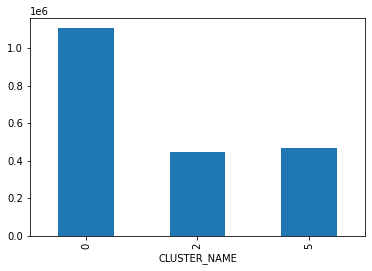

In [279]:
compras_df.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot.bar()